In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import cPickle as pickle

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [2]:
pd.options.display.max_rows = 50
pd.options.display.max_columns = 120

In [3]:
with open('pickles/df.pkl', 'rb') as f:
    df = pickle.load(f)
    
with open('pickles/drop_cols1.pkl', 'rb') as f:
    drop_cols = pickle.load(f)
    
    
with open('pickles/gboost3.pkl', 'rb') as f:
    gboost = pickle.load(f)

### Categories:
    - Stores
    - Ancestry
    - Marriage
    - Population (age and gender)
    - Schooling
    - Income
    - Race
    - Habits
    - Health

In [4]:
# keeping these because I'm interested...
# they actually do improve the model a tiny bit
drop_cols.remove('Female_Divorced_pct')
drop_cols.remove('Female_Single_pct')

### Remove Redundancy

In [5]:
drop_cols.extend(['Female_Adult_Population_pct', 'Male_Adult_Population_pct', 'Over_25yrs_pct'])


In [7]:
df.drop(drop_cols, axis = 1).shape

(2375, 28)

In [8]:
# ALL OF NYC IS LABELED AS KINGS COUNTY
# CHANGING IT TO NEW YORK COUNTY
df.loc[df.county == 'New York County', 'wholefoods'] = 8
df.loc[df.county == 'New York County', 'Y'] = 1

df.loc[(df.county == 'Kings County') & (df.state == 'New York'), 'wholefoods'] = 2



### Get Feature Importances and Coefs

In [9]:
weights = [0.3 if v == 0 else 0.7 for v in df.Y]
def Oversample_Classification(est, data, drop, target, weights, cv, train_size):
    '''
    Does Cross_Validation with oversampling.
    data is your dataframe
    drop is columns to drop to get your x variable
    target is your y variable
    weights should be a series that maps to x and y the weight for each row 
    (eg all the rows of class one should have distinct weight and all rows of class2 have other distinct weight)
    '''

    accuracy = []
    pr = []
    auc = []
    ftr_importances = []


    for f in range(cv):
        train = data.sample(train_size, weights = weights, replace=True)
        test = data[~data.index.isin(train.index)]
        x = train.drop(drop, axis =1)
        x_train  = x
        y_train = train[target]

        x_test = test.drop(drop, axis = 1)
        y_test = test[target]

        est.fit(x_train,y_train)
        preds = est.predict(x_test)
        probs = est.predict_proba(x_test)

        
        accuracy.append(metrics.accuracy_score(y_test, preds))
        pr.append((metrics.precision_score(y_test, preds), metrics.recall_score(y_test,preds)))
        auc.append(metrics.roc_auc_score(y_test, probs[:,1]))
        
        try: 
            ftr_importances.append(est.coef_)
        except:
            try:
                ftr_importances.append(est.feature_importances_)
            except:
                ftr_importances = 'no ftr_importances'
            
       
    print('--------------')
    print('Accuracy:',np.mean(accuracy))
    print('Precision:',np.array(pr)[:,0].mean())
    print('Recall:', np.array(pr)[:,1].mean())
    print('AUC:',np.mean(auc))
    print('--------------')

       
                
    print(np.array(ftr_importances).shape)
    if type(ftr_importances) == str:
        return ftr_importances
    
    
    
    return pd.DataFrame(np.array(ftr_importances).reshape(cv,len(data.drop(drop, axis = 1).columns)), columns = data.drop(drop, axis = 1).columns)

GET FEATURE IMPORTANCES FROM LOGREG AND GBOOST

In [10]:
logReg = LogisticRegression(C=0.8, max_iter = 250)
coefs = Oversample_Classification(logReg, df, drop_cols, 'Y', weights, 100, 1500)

--------------
('Accuracy:', 0.96676932761422707)
('Precision:', 0.54900918719805247)
('Recall:', 0.79457669822774724)
('AUC:', 0.98025084996447676)
--------------
(100, 1, 28)


In [11]:
gb_ftr_importances = Oversample_Classification(gboost, df, drop_cols, 'Y', weights, 50, 1500)


--------------
('Accuracy:', 0.97298815066294286)
('Precision:', 0.62124096817724639)
('Recall:', 0.7796402035411405)
('AUC:', 0.98081425837965408)
--------------
(50, 28)


In [12]:
train = df.sample(1500,replace = True, weights = weights, random_state = 3333)
test = df[~df.index.isin(train.index)]

print train.Y.value_counts() 
print train[train.Y == 1].index.nunique()



x_train = train.drop(drop_cols, axis = 1)
y_train = train.Y

x_test = test.drop(drop_cols, axis =1)
y_test = test.Y




gboost.fit(x_train, y_train)
preds = gboost.predict(x_test)
probs = gboost.predict_proba(x_test)

print '----------------------'
print 'Accuracy:', metrics.accuracy_score(y_test, preds)
print 'AUC:', metrics.roc_auc_score(y_test, probs[:,1])

print metrics.classification_report(y_test, preds)
print '----------------------'

0    1263
1     237
Name: Y, dtype: int64
133
----------------------
Accuracy: 0.965675057208
AUC: 0.987153422317
             precision    recall  f1-score   support

          0       0.99      0.97      0.98      1257
          1       0.56      0.83      0.67        54

avg / total       0.97      0.97      0.97      1311

----------------------


Make a DF that allows for comparison of results and evaluating with different probability thresholds

In [13]:
res = pd.DataFrame({'preds': preds, 'probC0': probs[:,0], 'probC1': probs[:,1]})
res = pd.concat([y_test.reset_index(drop=True), res], ignore_index=True, axis = 1)
res.columns = ['Actual', 'Predicted', 'Prob0','Prob1']
res.head(10)

,Actual,Predicted,Prob0,Prob1
0,1,1,0.005144,0.994856
1,1,1,0.005162,0.994838
2,1,1,0.005156,0.994844
3,0,0,0.880298,0.119702
4,1,1,0.005123,0.994877
5,1,1,0.183300,0.816700
6,0,1,0.195333,0.804667
7,1,1,0.006725,0.993275
8,1,1,0.012393,0.987607
9,1,1,0.017008,0.982992


I think best score is as is. Adjusting the threshold doesn't help much.

In [14]:
print '----------------------'
print 'Accuracy:', metrics.accuracy_score(res.Actual, [1 if p > 0.6 else 0 for p in res.Prob1.values])

print metrics.classification_report(res.Actual, [1 if p > 0.6 else 0 for p in res.Prob1.values])
print '----------------------'

----------------------
Accuracy: 0.968726163234
             precision    recall  f1-score   support

          0       0.99      0.97      0.98      1257
          1       0.58      0.83      0.69        54

avg / total       0.98      0.97      0.97      1311

----------------------


### Use Fitted Model to Generate Predictions For Entire DataFrame

For purpose of mapping in d3

In [15]:
preds = gboost.predict(df.drop(drop_cols, axis = 1))
probs = gboost.predict_proba(df.drop(drop_cols, axis = 1))

res = pd.DataFrame({'preds': preds, 'probC0': probs[:,0], 'probC1': probs[:,1]})
res = pd.concat([df.Y.reset_index(drop=True), res], ignore_index=True, axis = 1)
res.columns = ['Actual', 'Predicted', 'Prob0','Prob1']
res.head(10)

,Actual,Predicted,Prob0,Prob1
0,1,1,0.005140,0.994860
1,1,1,0.005143,0.994857
2,1,1,0.005160,0.994840
3,1,1,0.005144,0.994856
4,1,1,0.005162,0.994838
5,1,1,0.005123,0.994877
6,1,1,0.005123,0.994877
7,1,1,0.005156,0.994844
8,1,1,0.005145,0.994855
9,0,0,0.998945,0.001055


In [16]:
print '----------------------'
print 'Accuracy:', metrics.accuracy_score(res.Actual, [1 if p > 0.5 else 0 for p in res.Prob1.values])

print metrics.classification_report(res.Actual, [1 if p > 0.5 else 0 for p in res.Prob1.values])
print '----------------------'

----------------------
Accuracy: 0.981052631579
             precision    recall  f1-score   support

          0       1.00      0.98      0.99      2188
          1       0.83      0.95      0.89       187

avg / total       0.98      0.98      0.98      2375

----------------------


## Evaluate Incorrect Predictions

For possible reccomended exapantions

In [17]:
df.ix[res[(res.Actual == 0) & (res.Predicted == 1)].sort_values('Prob1', ascending = False).index, ['county','state']]
#res[(res.Actual == 0) & (res.Predicted == 1)].sort_values('Prob1', ascending = False)


,county,state
2324,Richmond city,Virginia
114,Lucas County,Ohio
318,Delaware County,Ohio
77,DeKalb County,Georgia
314,Passaic County,New Jersey
126,Bristol County,Massachusetts
71,Summit County,Ohio
156,New Castle County,Delaware
178,Hudson County,New Jersey
176,Williamson County,Texas


### Get Models to CSV

In [18]:
csvdf = pd.concat([df.drop(drop_cols, axis = 1), res], axis = 1)

In [19]:
csvdf.shape

(2375, 32)

In [20]:
csvdf = pd.concat([df[['fips','county','state', 'wholefoods', 'mcdonalds','walmart','target']], csvdf], axis = 1)


In [21]:
# RENAMING some columns so "pct" always comes at end of name
csvdf.columns = [u'fips', u'county', u'state', u'wholefoods', u'mcdonalds', u'walmart',
       u'target', u'population', u'starbucks', u'tjs',
       u'Ancestry_American_pct', u'Ancestry_Arab_pct', u'Ancestry_French_pct',
       u'Female_Adult_Population', u'Female_Divorced', u'Female_Divorced_pct',
       u'Female_Single', u'Female_Single_pct', u'Female_Widowed',
       u'In_School_pct', u'Graduated_College_pct',
       u'Highest_Education_Associates_Degree_pct',
       u'Highest_Education_Bachelors_Degree_pct',
       u'Highest_Education_Graduate_Degree_pct',
       u'Highest_Education_HS_Diploma_pct', u'Household_income_75k_100K_pct',
       u'Male_Adult_Population', u'Male_Divorced', u'Male_Single',
       u'Over_25yrs', u'hiv_prevalence_rate', u'asian_pct',
       u'native_hawaiian_other_pacific_islander_pct', u'obese_pct',
       u'rural_pct', u'Actual', u'Predicted', u'Prob0', u'Prob1']

In [22]:
csvdf.to_csv('WebApp/COUNTYDATA.csv', index = False)

In [23]:
csvdf = pd.read_csv('WebApp/COUNTYDATA.csv', dtype = {'fips':'str'})

## Analyze

look at ftrs

In [24]:
coefs.mean()[coefs.mean().abs().sort_values(ascending = False).index]

starbucks                                     0.069548
pct_obese                                    -0.062479
Highest_Education_HS_Diploma_pct             -0.061740
pct_rural                                    -0.051856
Graduated_College_pct                         0.035794
pct_asian                                     0.019195
Highest_Education_Bachelors_Degree_pct        0.018846
Highest_Education_Graduate_Degree_pct         0.016702
Highest_Education_Associates_Degree_pct      -0.015575
Ancestry_French_pct                           0.015348
Household_income_75k_100K_pct                -0.014391
pct_native_hawaiian_other_pacific_islander    0.011784
Ancestry_American_pct                        -0.009674
Female_Divorced_pct                          -0.009083
tjs                                           0.008306
Female_Single_pct                            -0.002765
hiv_prevalence_rate                           0.001911
Ancestry_Arab_pct                            -0.001038
Male_Singl

In [25]:
gb_ftr_importances.mean().sort_values(ascending = False)

starbucks                                     0.268335
Female_Single                                 0.103529
tjs                                           0.092518
Over_25yrs                                    0.055765
Female_Divorced                               0.047544
Female_Adult_Population                       0.040844
population                                    0.040091
Male_Single                                   0.037680
Male_Adult_Population                         0.035376
In_School_pct                                 0.029072
Graduated_College_pct                         0.024478
Highest_Education_Graduate_Degree_pct         0.022306
Highest_Education_HS_Diploma_pct              0.020820
Highest_Education_Bachelors_Degree_pct        0.017913
pct_obese                                     0.017900
Highest_Education_Associates_Degree_pct       0.017323
hiv_prevalence_rate                           0.016674
Household_income_75k_100K_pct                 0.014845
Ancestry_F

### Starbucks

In [29]:
sbucks_mask = (csvdf.starbucks>0)
wf_mask = (csvdf.wholefoods >0)
neg_mask = (csvdf.wholefoods == 0)

In [30]:
#What Percent of locations that have Starbucks also have a whole foods


csvdf[csvdf.starbucks >= 1].shape #1093
csvdf[sbucks_mask & (csvdf.wholefoods >=1)].shape # 187

187./1093

0.17108874656907594

In [31]:
#What Percent of locations that have WholeFoods also have a Starbucks
csvdf[csvdf.wholefoods >= 1].shape #187
csvdf[sbucks_mask & wf_mask].shape # 187

187/187

1

In [32]:
# What is the avg ratio of Starbucks to Wholefoods
(csvdf[sbucks_mask & wf_mask]['starbucks']/csvdf[sbucks_mask & wf_mask]['wholefoods']).sort_values().mean()


19.900207669274607

### Trader Joes

In [36]:
tj_mask = (csvdf.tjs>0)

print csvdf[tj_mask].shape #175
print csvdf[tj_mask & wf_mask].shape # 136

# 78% of counties that have a tjs also have a whole foods
float(csvdf[tj_mask & wf_mask].shape[0])/csvdf[tj_mask].shape[0]

(175, 39)
(136, 39)


0.7771428571428571

In [38]:
#What Percent of locations that have WholeFoods also have a Tjs
print csvdf[wf_mask].shape #187
print csvdf[tj_mask & wf_mask].shape # 136


# 73% of counties that have a whole foods also have a Tjs
csvdf[tj_mask & wf_mask].shape[0]/float(csvdf[wf_mask].shape[0])

(187, 39)
(136, 39)


0.7272727272727273

In [39]:
# What is the avg ratio of Tjs to Wholefoods
(csvdf[tj_mask & wf_mask]['tjs']/csvdf[tj_mask & wf_mask]['wholefoods']).sort_values().mean()


1.0918088356032067

### Population

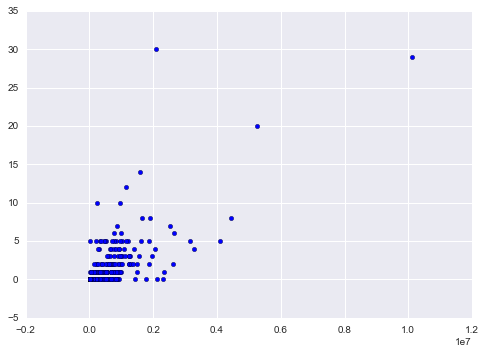

In [41]:
pop_mask = (csvdf.population>1000000)
plt.scatter(csvdf.population, csvdf.wholefoods)


In [44]:
# median population of counties with WF is 532K 
print csvdf[wf_mask].population.median() 

# only 4 counties with population greater than 1M that don't have whole foods
csvdf[pop_mask & neg_mask].county

532655.0


9              Wayne County
12    San Bernardino County
21            Queens County
53             Bronx County
Name: county, dtype: object

In [60]:
# Whole foods in counties with population > 1M make up 45% of all whole foods
print csvdf[pop_mask].wholefoods.sum()/csvdf.wholefoods.sum()

# but counties with pop > 1M containing WF only make up 20% of counties containing WF
print csvdf[pop_mask & wf_mask].shape[0]/float(csvdf[wf_mask].shape[0])

0.45
0.208556149733


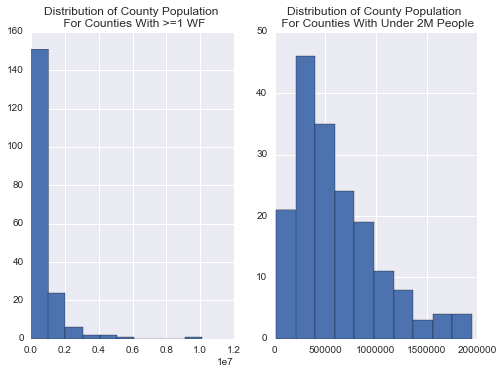

In [59]:
fig, (ax1, ax2) = plt.subplots(1,2)
csvdf[wf_mask].population.hist(ax = ax1)
csvdf[wf_mask & (csvdf.population <2000000)].population.hist(ax = ax2)
ax1.set_title('Distribution of County Population \n For Counties With >=1 WF')
ax2.set_title('Distribution of County Population \n For Counties With Under 2M People')

### Female Single

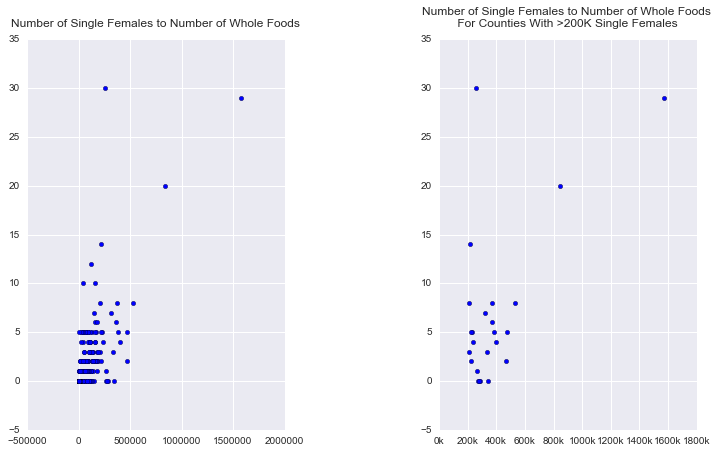

In [80]:
fsing_mask = (csvdf.Female_Single>200000)



fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,7))
ax1.scatter(csvdf.Female_Single, csvdf.wholefoods)
ax2.scatter(csvdf[fsing_mask].Female_Single, csvdf[fsing_mask].wholefoods)
ax1.set_title('Number of Single Females to Number of Whole Foods', y = 1.02)
ax2.set_title('Number of Single Females to Number of Whole Foods \n For Counties With >200K Single Females ', y = 1.02)
plt.subplots_adjust(wspace = 0.6)
nticks = len(ax2.get_xticklabels())
ax2.set_xticklabels([str(200*i) + 'k' for i in range(nticks)])

In [89]:
# Counties with > 200K single females makes up 32.5% of all WF stores
print csvdf[fsing_mask].wholefoods.sum()/csvdf.wholefoods.sum()

# Counties with > 200K single females make up 11% of all counties with WF stores
print csvdf[fsing_mask].Actual.sum()/float(csvdf.Actual.sum())

0.325
0.106951871658


In [93]:
# 65K Median single Female Population
print csvdf[wf_mask].Female_Single.median()

# Same 4 counties that are exceptions to this split
csvdf[fsing_mask & neg_mask]


65207.0


,fips,county,state,wholefoods,mcdonalds,walmart,target,population,starbucks,tjs,Ancestry_American_pct,Ancestry_Arab_pct,Ancestry_French_pct,Female_Adult_Population,Female_Divorced,Female_Divorced_pct,Female_Single,Female_Single_pct,Female_Widowed,In_School_pct,Graduated_College_pct,Highest_Education_Associates_Degree_pct,Highest_Education_Bachelors_Degree_pct,Highest_Education_Graduate_Degree_pct,Highest_Education_HS_Diploma_pct,Household_income_75k_100K_pct,Male_Adult_Population,Male_Divorced,Male_Single,Over_25yrs,hiv_prevalence_rate,asian_pct,native_hawaiian_other_pacific_islander_pct,obese_pct,rural_pct,Actual,Predicted,Prob0,Prob1
9,26163,Wayne County,Michigan,0.0,88.0,9.0,9.0,1764804.0,41.0,2.0,4.9,4.6,2.7,753229.0,97858.0,13.0,284776.0,37.8,78665.0,488306.0,21.6,7.6,13.1,8.5,30.3,10.3,676263.0,72334.0,293220.0,1172375.0,471.0,3.0,0.0,34.0,0.7,0,0,0.998945,0.001055
12,06071,San Bernardino County,California,0.0,73.0,20.0,13.0,2112619.0,106.0,3.0,4.1,0.8,1.7,810867.0,94691.0,11.7,270759.0,33.4,57787.0,630419.0,18.8,8.0,12.1,6.7,26.3,12.8,788177.0,68484.0,313701.0,1256972.0,205.0,7.3,0.5,29.0,4.7,0,0,0.572980,0.427020
21,36081,Queens County,New York,0.0,62.0,0.0,2.0,2321580.0,39.0,1.0,3.5,0.9,0.5,985069.0,91092.0,9.2,344824.0,35.0,94404.0,551047.0,30.2,7.8,19.3,10.9,27.3,13.1,905776.0,55067.0,378641.0,1598824.0,844.0,25.8,0.2,24.0,0.0,0,1,0.255646,0.744354
53,36005,Bronx County,New York,0.0,42.0,0.0,0.0,1438159.0,11.0,0.0,2.4,0.5,0.2,599664.0,65209.0,10.9,280150.0,46.7,51812.0,401135.0,18.3,6.9,11.8,6.5,27.7,8.9,508969.0,38828.0,262987.0,880909.0,2018.0,4.4,0.4,29.0,0.0,0,0,0.998945,0.001055


### Graducation Pct

18.4


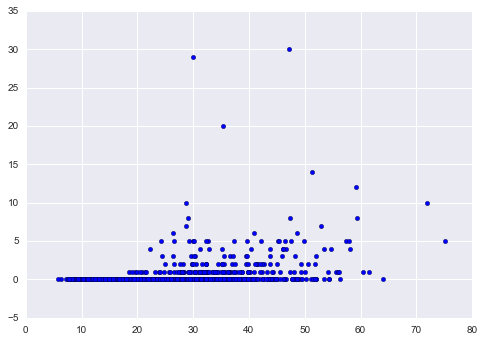

In [43]:
grad_mask = (csvdf.Graduated_College_pct>=35)
plt.scatter(csvdf.Graduated_College_pct, csvdf.wholefoods)

# Median College Grad Pct in America is 18%...
print csvdf.Graduated_College_pct.median()

0.605769230769
0.51871657754
0.0888421052632


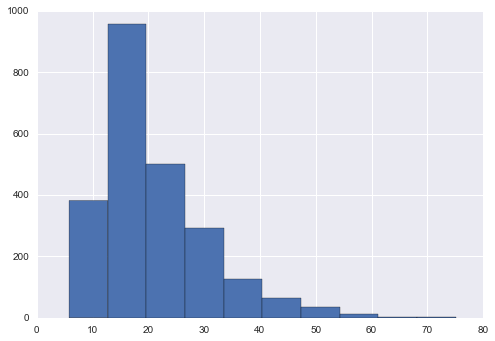

In [44]:
# 60.5% of all wholefoods are in counties with graduation rates >= 35%
print csvdf[grad_mask].wholefoods.sum()/csvdf.wholefoods.sum()

# Counties with graduation rates > 35% make up 50% of all Counties that contain WF
print csvdf[grad_mask].Actual.sum()/float(csvdf.Actual.sum())

csvdf.Graduated_College_pct.hist()
# only 9% of counties have a graduation rate higher than 35%
print csvdf[grad_mask].shape[0]/float(len(csvdf))


### Obesity

31.0


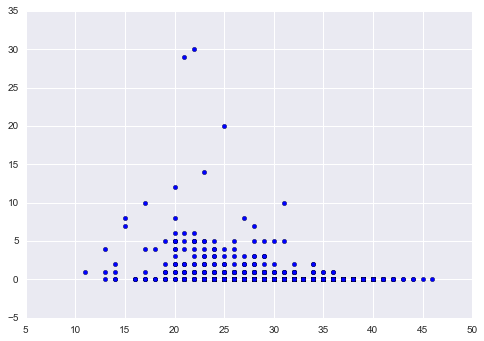

In [45]:
obs_mask = (csvdf.obese_pct<=30)
plt.scatter(csvdf.obese_pct, csvdf.wholefoods)

# Median Obesity Pct in America is 31%
print csvdf.obese_pct.median()

0.925
0.877005347594
25.0


,wholefoods,obese_pct
wholefoods,1.00000,-0.22606
obese_pct,-0.22606,1.00000


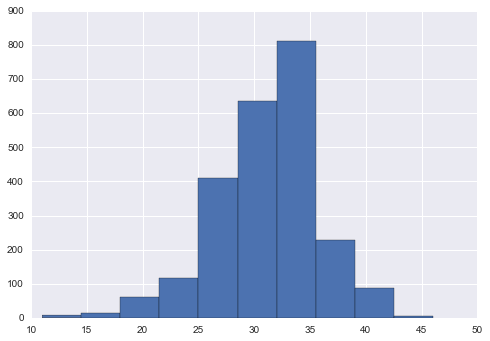

In [52]:
# 92% of all wholefoods are in counties with obesity rates <= 30%
print csvdf[obs_mask].wholefoods.sum()/csvdf.wholefoods.sum()

# Counties with graduation rates < 30% make up 87% of all Counties that contain WF
print csvdf[obs_mask].Actual.sum()/float(csvdf.Actual.sum())

# this is the only normally distributed variable I've seen so far...
csvdf.obese_pct.hist()

# median obesity for counties containing WholeFoods is 25%
print csvdf[wf_mask].obese_pct.median()

csvdf[wf_mask][['wholefoods','obese_pct']].corr()